Data directory is data\MNIST
Output Shape of the first convolution layer: (8, 28, 28) 

Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 

Output Shape of the second convolution layer: (16, 12, 12) 

Training 5994 parameters in 6 parameter tensors.
Minibatch: 0, Loss: 2.3097, Error: 75.00%
Minibatch: 500, Loss: 0.0893, Error: 0.00%
Minibatch: 1000, Loss: 0.1183, Error: 0.00%
Minibatch: 1500, Loss: 0.0999, Error: 0.00%
Minibatch: 2000, Loss: 0.0881, Error: 0.00%
Minibatch: 2500, Loss: 0.0310, Error: 0.00%
Minibatch: 3000, Loss: 0.0032, Error: 0.00%
Minibatch: 3500, Loss: 0.3911, Error: 12.50%
Minibatch: 4000, Loss: 0.5703, Error: 25.00%
Minibatch: 4500, Loss: 0.0267, Error: 0.00%
Minibatch: 5000, Loss: 0.0043, Error: 0.00%
Minibatch: 5500, Loss: 0.2868, Error: 12.50%
Minibatch: 6000, Loss: 0.0165, Error: 0.00%
Minibatch: 6500, Loss: 0.0719, Error: 0.00%
Minibatch: 7000, Loss: 0.0603, Error: 0.00%
Minibatch: 7500, Loss: 0.0015, Error: 0.00%
Minibatch: 8000, L

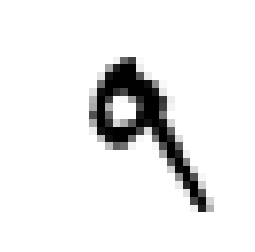

In [1]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

%matplotlib inline


# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))
        
        
# Test for CNTK version
if not C.__version__ == "2.5.1":
    raise Exception("this notebook is designed to work with 2.0. Current Version: " + C.__version__) 
    
    
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10



# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)


# Ensure the training and test data is available
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data")
    
print("Data directory is {0}".format(data_dir))



x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)


# function to build model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(1,1), 
                                       pad=True, name='first_conv')(h)
            
            h = C.layers.AveragePooling((5,5), strides = (2,2))(h)
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name='second_conv')(h)
            
            h = C.layers.AveragePooling((5,5), strides = (2,2))(h)
            
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r



# Create the model
z = create_model(x)
# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape,'\n')
print("Bias value of the last dense layer:", z.classify.b.value,'\n')
# Print the output shapes / parameters of different components of second layer
print("Output Shape of the second convolution layer:", z.second_conv.shape,'\n')


# Number of parameters in the network
C.logging.log_number_of_parameters(z)


def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)


# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error



def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.085
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 8
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print('\n',"Training took {:.1f} sec".format(time.time() - start),'\n')
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test),'\n')
    
    

def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()



out = C.softmax(z)


# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]



# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]


print("Label    :", gtlabel[:25])
print("Predicted:", pred)
print('\n')

# Plot a random image
sample_number = 7
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)